# Demo main

In [1]:
from preprocess.tissue_mask import GaussianTissueMask
from preprocess.utils import describe_img, read_image, get_tissue_mask, get_image_patches, resize_patch, normalize_patch, convert_patch_to_tensor

from osgen.loss import structure_preservation_loss, color_alignment_loss, content_loss, style_loss, total_loss
from osgen.pipeline import StyleTransferPipeline
from osgen.vit import extract_style_embedding

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("darkgrid")
from PIL import Image

/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define hyperparameters

In [2]:
Image.MAX_IMAGE_PIXELS = 100000000000

IMAGE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/HE/A3_TMA_15_02_IVB_HE.png"
STYLE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/NKX3/A6_TMA_15_02_IIB_NKX.png"

# tissue mask params
tissue_mask_params = {
    'kernel_size': 20,
    'sigma': 20,
    'downsample': 8,
    'background_gray_threshold': 220
}

# patch extraction params
patch_extraction_params = {
    'patch_size': 128,
    'patch_tissue_threshold': 0.7,
    'is_visualize': False
}

## Process patches

In [3]:
image_src = read_image(IMAGE_PATH)
image_dst = read_image(STYLE_PATH)

In [4]:
tissue_mask_src = get_tissue_mask(image=image_src, **tissue_mask_params)
tissue_mask_dst = get_tissue_mask(image=image_dst, **tissue_mask_params)

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737
Original size: 5684x5684
Downsampling factor: 8
New size: 710x710


In [5]:
# extract src patches
patches_src = get_image_patches(
    image=image_src,
    tissue_mask=tissue_mask_src,
    **patch_extraction_params
)

# extract dst patches
patches_dst = get_image_patches(
    image=image_dst,
    tissue_mask=tissue_mask_dst,
    **patch_extraction_params
)

## Load patches

In [6]:
batch_size = 1
batch_src = patches_src[:batch_size]
batch_dst = patches_dst[:batch_size]

batch_src = torch.Tensor(batch_src).permute(0, 3, 1, 2)
batch_dst = torch.Tensor(batch_dst).permute(0, 3, 1, 2)

# Check shape
print(batch_src.shape)
print(batch_dst.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


/var/folders/9t/hj30jvr52kscxxdg1z2kq1600000gn/T/ipykernel_46396/208333741.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  batch_src = torch.Tensor(batch_src).permute(0, 3, 1, 2)


# Test

In [7]:
tmp = StyleTransferPipeline()
style_emb = extract_style_embedding(patches_dst[0], device='cpu')
out = tmp(batch_src[0].unsqueeze(0), style_emb, torch.Tensor([0,200,400,1000]))

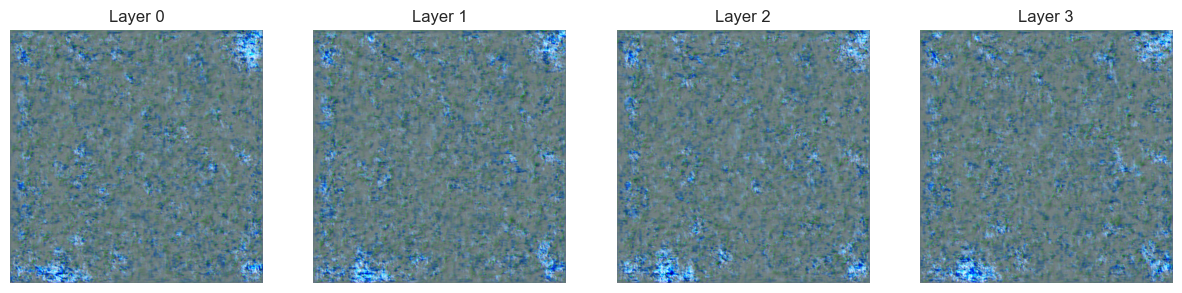

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(len(out)):
    ax[i].imshow(out[i].detach().numpy().transpose(1, 2, 0))
    ax[i].axis('off')
    ax[i].set_title(f'Layer {i}')
plt.show()

In [9]:
batch_src[0].unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [10]:
total_loss(batch_src[0].unsqueeze(0), out[0].unsqueeze(0))

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 90456.703125
Color Loss: 0.015352042391896248
Content Loss: 15984.3740234375
Style Loss: 146095.484375


tensor(252536.5781, grad_fn=<AddBackward0>)

# Dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import random 
random.seed(42)

class PatchDataset(Dataset):
    def __init__(self, path_src, path_dst, tissue_mask_params, patch_extraction_params, batch_size):
        self.image_src = read_image(path_src)
        self.image_dst = read_image(path_dst)
        self.tissue_mask_src = get_tissue_mask(image=self.image_src, **tissue_mask_params)
        self.tissue_mask_dst = get_tissue_mask(image=self.image_dst, **tissue_mask_params)
        self.patch_extraction_params = patch_extraction_params
        self.patches_src = get_image_patches(
            image=self.image_src,
            tissue_mask=self.tissue_mask_src,
            **patch_extraction_params
        )
        self.patches_dst = get_image_patches(
            image=self.image_dst,
            tissue_mask=self.tissue_mask_dst,
            **patch_extraction_params
        )
        self.batch_size = batch_size
        self.batch = self.patches_src[:batch_size]

        # Preprocess batch
        for i in range(len(self.batch)):
            self.batch[i] = resize_patch(self.batch[i])
            self.batch[i] = normalize_patch(self.batch[i])
        
        self.batch = convert_patch_to_tensor(self.batch)

    def __len__(self):
        return len(self.batch)

    def __getitem__(self, idx):
        return self.batch[idx], self.patches_dst[np.random.randint(len(self.patches_dst))]        

In [12]:
# Create dataset
batch_size = 1
dataset = PatchDataset(IMAGE_PATH, STYLE_PATH, tissue_mask_params, patch_extraction_params, batch_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737
Original size: 5684x5684
Downsampling factor: 8
New size: 710x710


In [13]:
dataset.patches_dst[0].shape

(128, 128, 3)

In [14]:
for batch, style in dataloader:
    print(batch.shape)
    print(style[0].numpy().shape)
    print()

torch.Size([1, 3, 32, 32])
(128, 128, 3)



# Train

In [15]:
from tqdm import tqdm
import torch.optim as optim
import time

In [61]:
# Hyperparameters
device = 'cpu'
learning_rate = 1e-3
num_epochs = 1
gradient_clip_val = 1.0
log_interval = 10
batch_size = 20

# Create dataset
dataset = PatchDataset(IMAGE_PATH, STYLE_PATH, tissue_mask_params, patch_extraction_params, batch_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


# Initialize model
model = StyleTransferPipeline(device=device)
model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

# Initialize optimizer with weight decay for regularization
optimizer = optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=learning_rate,
    weight_decay=1e-5
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2,
    verbose=True
)

# Track losses
losses = []
val_losses = []

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737
Original size: 5684x5684
Downsampling factor: 8
New size: 710x710
Number of trainable parameters: 731720


In [ ]:
for epoch in range(num_epochs):
    epoch_loss = 0.0

    print(f"Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    for batch_idx in tqdm(range(len(dataloader))):
        # Get batch
        batch, style = next(iter(dataloader))
        batch = batch.to(device)
        style = style.to(device)

        # Extract style embedding
        style_emb = extract_style_embedding(style[0].numpy(), device=device)
        # print(style_emb.shape)

        # Clear gradients
        optimizer.zero_grad()

        # Create timesteps
        timesteps = torch.Tensor([0, 200, 400, 1000]).to(device)
        
        # Forward pass
        out = model(batch, style_emb, timesteps)
        # print(batch.shape)
        loss = total_loss(batch, out[0].unsqueeze(0))
        print("Min vs Max batch: ", batch.min(), batch.max())
        print("Min vs Max out: ", out[0].min(), out[0].max())
        print("Total loss: ", loss,"\n")

        # Backward pass with gradient scaling for stability
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(
            [p for p in model.parameters() if p.requires_grad],
            gradient_clip_val
        )
        losses.append(loss)

        # Update parameters
        optimizer.step()

        # Update statistics
        epoch_loss += loss.item()

        # Log progress
        if (batch_idx + 1) % log_interval == 0:
            print(f"  Batch {batch_idx+1}/{batch_size}, Loss: {loss.item():.6f}")


    # # Compute average epoch loss
    # avg_epoch_loss = epoch_loss / batch_size
    # losses.append(avg_epoch_loss)
    
    # Print epoch stats
    print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

Epoch 1/1


  0%|          | 0/20 [00:00<?, ?it/s]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 171259.984375
Color Loss: 0.015625
Content Loss: 83857.078125
Style Loss: 119376.3046875
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.1210, grad_fn=<MinBackward1>) tensor(0.8871, grad_fn=<MaxBackward1>)
Total loss:  tensor(374493.3750, grad_fn=<AddBackward0>) 



  5%|▌         | 1/20 [00:04<01:30,  4.78s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 188037.03125
Color Loss: 0.015625
Content Loss: 89275.75
Style Loss: 159958.25
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0889, grad_fn=<MinBackward1>) tensor(0.9165, grad_fn=<MaxBackward1>)
Total loss:  tensor(437271.0625, grad_fn=<AddBackward0>) 



 10%|█         | 2/20 [00:09<01:29,  4.95s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 188160.359375
Color Loss: 0.015625
Content Loss: 83686.1015625
Style Loss: 141786.078125
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0532, grad_fn=<MinBackward1>) tensor(0.9531, grad_fn=<MaxBackward1>)
Total loss:  tensor(413632.5625, grad_fn=<AddBackward0>) 



 15%|█▌        | 3/20 [00:15<01:29,  5.26s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 180844.21875
Color Loss: 0.015625
Content Loss: 73995.3359375
Style Loss: 173455.71875
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0688, grad_fn=<MinBackward1>) tensor(0.9089, grad_fn=<MaxBackward1>)
Total loss:  tensor(428295.2812, grad_fn=<AddBackward0>) 



 20%|██        | 4/20 [00:20<01:19,  4.97s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 174809.578125
Color Loss: 0.015625
Content Loss: 66866.40625
Style Loss: 173011.75
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0171, grad_fn=<MinBackward1>) tensor(0.9597, grad_fn=<MaxBackward1>)
Total loss:  tensor(414687.7500, grad_fn=<AddBackward0>) 



 25%|██▌       | 5/20 [00:24<01:11,  4.79s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 203143.75
Color Loss: 0.015624999068677425
Content Loss: 72416.765625
Style Loss: 155534.53125
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0070, grad_fn=<MinBackward1>) tensor(0.9834, grad_fn=<MaxBackward1>)
Total loss:  tensor(431095.0625, grad_fn=<AddBackward0>) 



 30%|███       | 6/20 [00:28<01:04,  4.64s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 182640.0
Color Loss: 0.015624999068677425
Content Loss: 64127.01171875
Style Loss: 158098.671875
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0693, grad_fn=<MinBackward1>) tensor(0.9093, grad_fn=<MaxBackward1>)
Total loss:  tensor(404865.6875, grad_fn=<AddBackward0>) 



 35%|███▌      | 7/20 [00:33<01:00,  4.62s/it]

Original and generated images have different shapes. Resizing generated image to match original image.
Structure Loss: 181620.03125
Color Loss: 0.015624999068677425
Content Loss: 58813.1328125
Style Loss: 178777.515625
Min vs Max batch:  tensor(0.) tensor(255.)
Min vs Max out:  tensor(0.0058, grad_fn=<MinBackward1>) tensor(0.9862, grad_fn=<MaxBackward1>)
Total loss:  tensor(419210.6875, grad_fn=<AddBackward0>) 



 40%|████      | 8/20 [00:38<00:56,  4.67s/it]

In [ ]:
t = []
for i in range(len(losses)):
    if i>0:
        t.append(losses[i].item())
    else:
        t.append(losses[i])

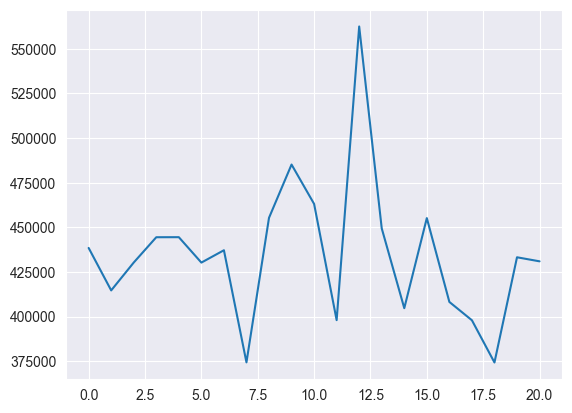

In [ ]:
plt.plot(t)

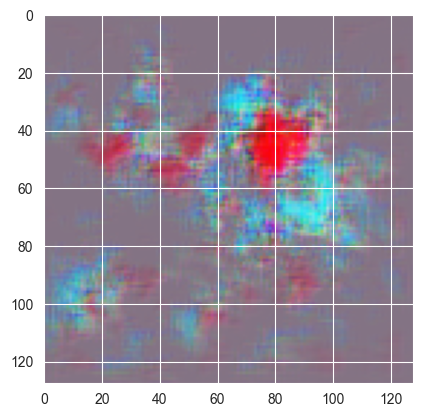

In [ ]:
plt.imshow(out[0].detach().numpy().transpose(1, 2, 0))